In [1]:
import sys
sys.path.append("../src/")
from data import train_and_testloader_from_pc, dataloader_from_pc
from model import AEDist
import numpy as np
import torch
import phate
from heatgeo.embedding import HeatGeo
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from scipy.spatial import procrustes
import scanpy as sc
import scprep
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import wandb
import hydra
import os
from omegaconf import DictConfig, OmegaConf
import wandb
from hydra import initialize, compose
import pickle

In [2]:
adata = sc.read('../data/BMMC_myeloid.h5ad', backed='r')

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [ ]:
initialize(config_path="../conf")
cfg = compose(config_name='config')

In [ ]:
if cfg.model.activation == 'relu':
    activation_fn = torch.nn.ReLU()
elif cfg.model.activation == 'leaky_relu':
    activation_fn = torch.nn.LeakyReLU()
elif cfg.model.activation == 'sigmoid':
    activation_fn = torch.nn.Sigmoid()
else:
    raise ValueError('Unknown activation function')
ckpt_path = '../results/model.ckpt'
model = AEDist.load_from_checkpoint(
    ckpt_path,
    dim=adata.shape[1],
    emb_dim=adata.obsm["X_phate"].shape[1],
    log_dist=cfg.model.log_dist,
    w=cfg.model.w,
    lr=cfg.model.lr,
    activation_fn=activation_fn,
)

In [ ]:
with open('../results/procrustes.pkl', 'rb') as file:
    procrustes = pickle.load(file)

In [19]:
X_tensor = torch.from_numpy(adata[:,:].X).float()
xhat, z = model(X_tensor)
xhat = xhat.cpu().detach().numpy()
z = z.cpu().detach().numpy()

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/scatter.py:753: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/scatter.py:753: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(


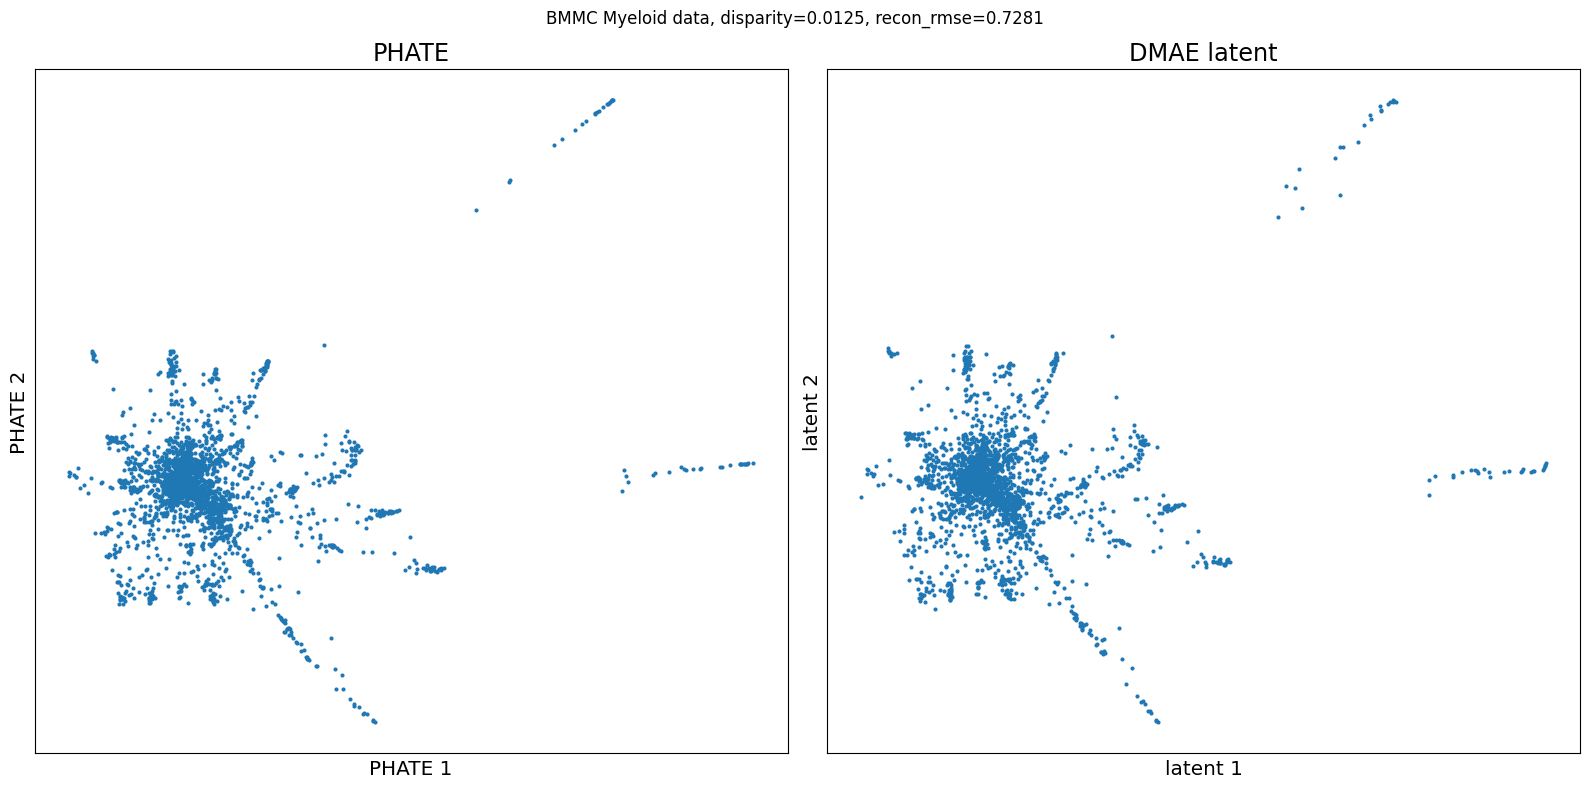

In [20]:
recon_rmse = np.sqrt(np.square(xhat - X_tensor.numpy()).mean())

z_rot = procrustes.transform(z)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first scatter plot
scprep.plot.scatter2d(adata.obsm['X_phate'], ax=axes[0], cmap="Spectral",
                      ticks=False, label_prefix="PHATE ", title='PHATE')

# Plot the second scatter plot
scprep.plot.scatter2d(z_rot, ax=axes[1], cmap="Spectral",
                      ticks=False, label_prefix="latent ", title='DMAE latent')
plt.suptitle(f"BMMC Myeloid data, disparity={procrustes.disparity:.4f}, recon_rmse={recon_rmse:.4f}")
plt.tight_layout()
plt.show()